In [20]:
import pandas as pd
import numpy as np

from pyPRISMClimate import get_prism_monthlys, get_prism_monthly_single, get_prism_dailys, get_prism_daily_single, get_prism_normals
from pyPRISMClimate.utils import prism_iterator

import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import plot, mask

import geopandas as gpd
import fiona

from metloom.pointdata import MesowestPointData, SnotelPointData
from datetime import datetime
import os 
import pathlib
import warnings


In [50]:
# Get monthly mean temperature
get_prism_monthlys(variable='ppt', years=[2017,2018], months=[5,6,7], dest_path='tmp/prism')
# # Get the 30 year normal temperature for Jan, Feb, Mar at 800m resolution.
# get_prism_normals(variable = 'tmean', resolution = '800m', months=[1,2,3],
#                   dest_path = './')

# # Get the 30 year annual temperature at 4km resolution.
# get_prism_normals(variable = 'tmean', resolution = '4km', annual=True,
#                   dest_path = './')

In [6]:
prism_files = prism_iterator('./tmp/prism')

'./tmp/prism\\PRISM_ppt_stable_4kmM3_201705_bil.bil'

In [2]:
# Get polygon to clip to
fiona.drvsupport.supported_drivers['KML'] = 'rw'
east_river_polygon = gpd.read_file("../multisite/data/polygons/East_River.kml", driver='KML')
east_river_polygon = east_river_polygon.to_crs("26913")

In [3]:
# Convert to new CRS using rasterio
# From https://hatarilabs.com/ih-en/how-to-reproject-single-and-multiple-rasters-with-python-and-rasterio-tutorial
def transform_prism(prism_file_path):
    print('Transforming: ' + prism_file_path)
    src = rasterio.open(prism_file_path)
    print('Source CRS:')
    print(src.crs)

    dstCrs = {'init':'EPSG:26913'}
    print('Destination raster crs:')
    print(dstCrs)

    # calculate transform array and shape of reprojected raster
    transform, width, height = calculate_default_transform(
            src.crs, dstCrs, src.width, src.height, *src.bounds)

    print("transform array of source raster")
    print(src.transform)

    #working of the meta for the destination raster
    kwargs = src.meta.copy()
    kwargs.update({
            'crs': dstCrs,
            'transform': transform,
            'width': width,
            'height': height
        })

    new_name = prism_file_path[:-4] + '_rpj.bil'
    #open destination raster
    dstRst = rasterio.open(new_name, 'w', **kwargs)

    #reproject and save raster band data
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=rasterio.band(dstRst, i),
            #src_transform=src.transform,
            src_crs=src.crs,
            #dst_transform=transform,
            dst_crs=dstCrs,
            resampling=Resampling.nearest)

    #close destination raster
    dstRst.close()
    return new_name

In [262]:
# dstRst.close()
# new_name = transform_prism(prism_files[2]['full_path'])
# dstRst = rasterio.open(new_name)


In [4]:
# pull in snotel data for comparison and plot points on map
# Pull Butte snotel data

snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_sntl = snotel_point.get_daily_data(
    datetime(1991, 1, 1), datetime(2022, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP,
     snotel_point.ALLOWED_VARIABLES.RH]
)
butte_sntl = butte_sntl.droplevel(1)

# Add water year
butte_sntl['water_year'] =  butte_sntl.index.year.where(butte_sntl.index.month < 10, butte_sntl.index.year + 1)

# Get dates of max swe
butte_sntl.index = pd.to_datetime(butte_sntl.index)

snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
schofield_sntl = snotel_point.get_daily_data(
    datetime(1991, 1, 1), datetime(2022, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP,
     snotel_point.ALLOWED_VARIABLES.RH]
)
schofield_sntl = schofield_sntl.droplevel(1)

# Add water year
schofield_sntl['water_year'] =  schofield_sntl.index.year.where(schofield_sntl.index.month < 10, schofield_sntl.index.year + 1)
schofield_sntl.index = pd.to_datetime(schofield_sntl.index)

No RELATIVE HUMIDITY found for Butte
No RELATIVE HUMIDITY found for Schofield Pass


In [5]:
if butte_sntl.crs is None:
    butte_sntl=butte_sntl.set_crs(crs='EPSG:4326')
    butte_sntl=butte_sntl.to_crs(crs=26913)

In [6]:
if schofield_sntl.crs is None:
    schofield_sntl=schofield_sntl.set_crs(crs='EPSG:4326')
    schofield_sntl=schofield_sntl.to_crs(crs=26913)

In [197]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
# Uses 1500 meter buffer to match
src_ma, src_ma_transform = rasterio.mask.mask(dstRst, east_river_polygon.buffer(1500),**rio_mask_kwargs)
east_ma_extent = rasterio.plot.plotting_extent(src_ma, src_ma_transform)

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_5336\974017476.py:8: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  butte_month= butte_sntl.loc[datetime(2017,7,1):datetime(2017,7,31)]
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_5336\974017476.py:22: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  jan_schofield = schofield_sntl.loc[datetime(2017,7,1):datetime(2017,7,31)]


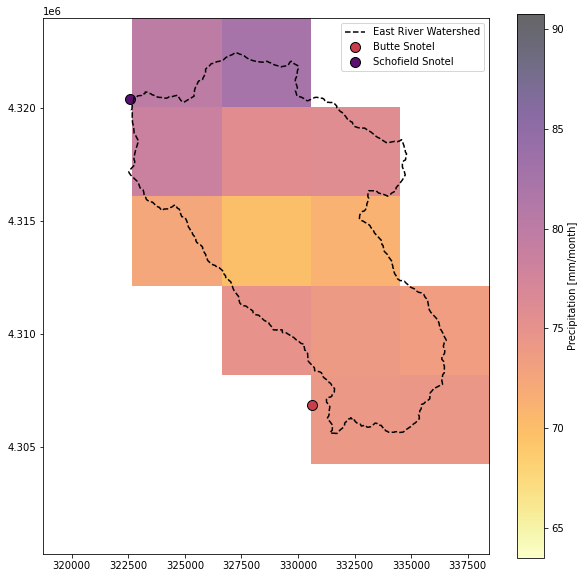

In [198]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

cax = ax.imshow(src_ma, extent=east_ma_extent, alpha=0.6, cmap='inferno_r',vmin=src_ma.min()/1.1, vmax = src_ma.max()*1.1)
plt.colorbar(cax, ax=ax, label='Precipitation [mm/month]')
east_river_polygon.boundary.plot(ax=ax,label='East River Watershed', color='k', ls='--')

butte_month= butte_sntl.loc[datetime(2017,7,1):datetime(2017,7,31)]
butte_month_accum = butte_month['PRECIPITATON'].sum()*25.4

ax.scatter(x=butte_sntl.geometry.x.iloc[0],
           y=butte_sntl.geometry.y.iloc[0],
           c=butte_month_accum, 
           label='Butte Snotel',
           marker='o', 
           ec='k', 
           s=100,
           cmap='inferno_r',
           vmin=src_ma.min()/1.1, 
           vmax = src_ma.max()*1.1)

jan_schofield = schofield_sntl.loc[datetime(2017,7,1):datetime(2017,7,31)]
jan_schofield_accum = jan_schofield['PRECIPITATON'].sum()*25.4
ax.scatter(x=schofield_sntl.geometry.x.iloc[0],
           y=schofield_sntl.geometry.y.iloc[0],
           c=jan_schofield_accum, 
           label='Schofield Snotel',
           marker='o', 
           ec='k', 
           s=100,
           cmap='inferno_r',
           vmin=src_ma.min()/1.1, 
           vmax = src_ma.max()*1.1)

ax.legend()




In [212]:
src_ma, src_ma_transform = rasterio.mask.mask(dstRst, butte_sntl.geometry,**rio_mask_kwargs)
east_ma_extent = rasterio.plot.plotting_extent(src_ma, src_ma_transform)

In [31]:
# make a time series comparing PRSIM data to observations in the valley and around. Add in billy barr data and snodgrass mountain.
# Then lets start looking at snow depth maps from ASO. Need to start working on the linux box for this 

years = np.arange(2015,2022,1).tolist()
months = np.arange(1,13,1).tolist()
butte_accum_all = pd.DataFrame(index=months, columns=years)
butte_prism_accum_all = butte_accum_all.copy()

schofield_accum_all = butte_accum_all.copy()
schofield_prism_accum_all = butte_accum_all.copy()

rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
for y in years:
    for m in months:
        # Get prism data
        prism_path = get_prism_monthly_single(variable='ppt', year=y, month=m, return_path=True, dest_path='./tmp/p')
        dstRst = rasterio.open(transform_prism(prism_path))
        
        # Get schofield monthly accumulated precipitation
        schofield = schofield_sntl.loc[(schofield_sntl.index.month==m) & (schofield_sntl.index.year==y)]
        schofield_accum = schofield['PRECIPITATON'].sum()*25.4
        schofield_prism_ma, schofield_prism_ma_transform = rasterio.mask.mask(dstRst, schofield_sntl.geometry,**rio_mask_kwargs)
        # Add to dataframes
        schofield_accum_all.loc[m,y] = schofield_accum
        schofield_prism_accum_all.loc[m,y] = np.ma.getdata(schofield_prism_ma)[0][0]

        # Get butte monthly accumulated precipitation
        butte = butte_sntl.loc[(butte_sntl.index.month==m) & (butte_sntl.index.year==y)]
        butte_accum = butte['PRECIPITATON'].sum()*25.4
        butte_prism_ma, butte_prism_ma_transform = rasterio.mask.mask(dstRst, butte_sntl.geometry,**rio_mask_kwargs)
        # Add to dataframes
        butte_accum_all.loc[m,y] = butte_accum
        butte_prism_accum_all.loc[m,y] = np.ma.getdata(butte_prism_ma)[0][0]

        if prism_path:
            dstRst.close()
            
            csv_files = pathlib.Path(os.path.dirname(prism_path))
            for csv_file in csv_files.glob('PRISM*'):
                try: csv_file.unlink()
                except CPLE_AppDefinedError: pass

        
        


Transforming: c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\sublimation_of_snow\notebooks\initial_codes\tmp\p/PRISM_ppt_stable_4kmM3_201501_bil.bil
Source CRS:
OGC:CRS83
Destination raster crs:
{'init': 'EPSG:26913'}
transform array of source raster
| 0.04, 0.00,-125.02|
| 0.00,-0.04, 49.94|
| 0.00, 0.00, 1.00|
Transforming: c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\sublimation_of_snow\notebooks\initial_codes\tmp\p/PRISM_ppt_stable_4kmM3_201502_bil.bil
Source CRS:
OGC:CRS83
Destination raster crs:
{'init': 'EPSG:26913'}
transform array of source raster
| 0.04, 0.00,-125.02|
| 0.00,-0.04, 49.94|
| 0.00, 0.00, 1.00|
Transforming: c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\sublimation_of_snow\notebooks\initial_codes\tmp\p/PRISM_ppt_stable_4kmM3_201503_bil.bil
Source CRS:
OGC:CRS83
Destination raster crs:
{'init': 'EPSG:26913'}
transform array of source raster
| 0.04, 0.00,-125.02|
| 0.00,-0.04, 49.94|
| 0.00, 0.00, 1.00|
Transforming: c:\Users\dlhogan\OneDrive - UW\Documents\

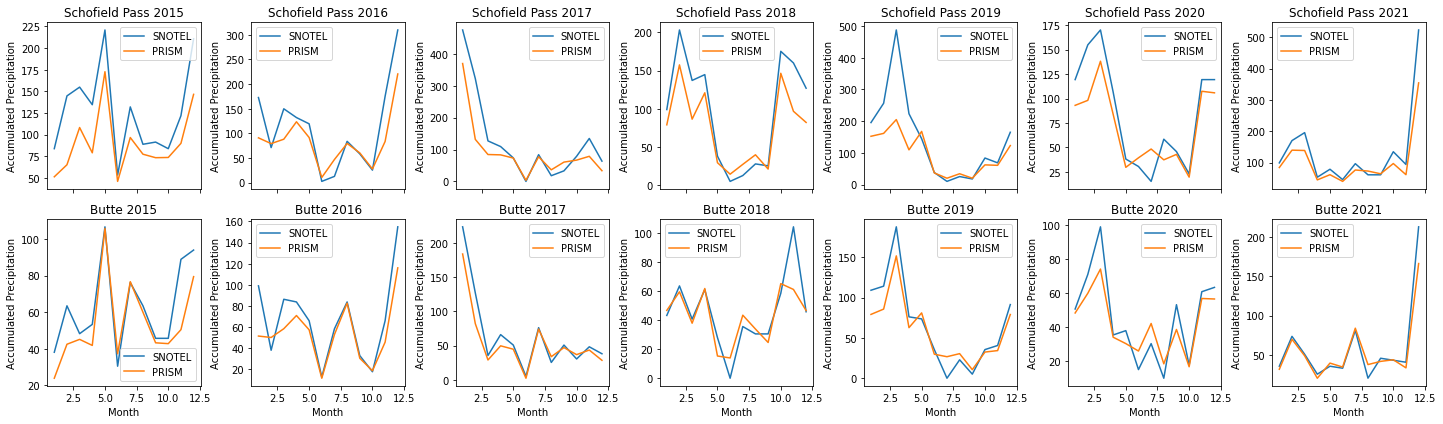

In [51]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=len(years),nrows=2, figsize=(20,6), tight_layout=True, sharex=True)
for i,year in enumerate(years):
    schofield_accum_all[year].plot(ax=ax[0,i], label='SNOTEL')
    schofield_prism_accum_all[year].plot(ax=ax[0,i], label='PRISM')
    ax[0,i].set_xlabel('Month')
    ax[0,i].set_ylabel('Accumulated Precipitation')
    ax[0,i].legend()
    ax[0,i].set_title(f'Schofield Pass {year}')
    butte_accum_all[year].plot(ax=ax[1,i], label='SNOTEL')
    butte_prism_accum_all[year].plot(ax=ax[1,i], label='PRISM')
    ax[1,i].legend()
    ax[1,i].set_title(f'Butte {year}')
    ax[1,i].set_xlabel('Month')
    ax[1,i].set_ylabel('Accumulated Precipitation')

